The code has been implemented in Keras. For performing model extraction attacks and defense we use IBM Art.
<br>
title = Adversarial Robustness Toolbox v1.2.0
<br>
author = Nicolae, Maria-Irina and Sinn, Mathieu and Tran, Minh~Ngoc and Buesser, Beat and Rawat, Ambrish and Wistuba, Martin and Zantedeschi, Valentina and Baracaldo, Nathalie and Chen, Bryant and Ludwig, Heiko and Molloy, Ian and Edwards, Ben
<br>
year = 2018
<br>
url = https://arxiv.org/pdf/1807.01069
<br>
github = https://github.com/Trusted-AI/adversarial-robustness-toolbox

# Cell 1
#Installing IBM Art

In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Cell 2
#Required imports

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import art
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import GaussianNoise

import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Cell 3
#Loading MNIST datatset

In [ ]:
#Loading the training dataset
#train_dataset.data represents the tensor of features. Shape is [NoofSamples,28,28]. 
#Min value 0 and max 255. 
#Data is not normalized but can be done by train_dataset.data = train_dataset.data/255
#train_dataset.targets represents the tensor of class labels. Shape is [NoofSamples]
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
# Selecting only classes 0 and 1 for LR
idx = (train_dataset.targets==0) | (train_dataset.targets==1)
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]/255.0

#Loading the test dataset
#test_dataset.data represents the tensor of features. Shape is [NoofSamples,28,28]. 
#Min value 0 and max 255. 
#Data is not normalized but can be done by test_dataset.data = test_dataset.data/255
#test_dataset.targets represents the tensor of class labels. Shape is [NoofSamples]
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
# Selecting classes 0 and 1 for LR
idx = (test_dataset.targets==0) | (test_dataset.targets==1)
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]/255.0

# Cell 4
# Creating Dataloaders

In [ ]:
#Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=64, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=64, 
                                          shuffle=False)

train_dataset.data=train_dataset.data.unsqueeze(1)
test_dataset.data=test_dataset.data.unsqueeze(1)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

# Cell 5
#Creating approximation function of ReLU and LR Model.

In [ ]:
# Approximate Sigmoid function
def sigmoid_approx(input):

    return  0.5 + 0.197*input - 0.004*input*input*input

#LR model using approximation
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(784, 1) #Input dimension is 784(28*28) and output is 1

    def forward(self, x):
        out = self.linear(x)
        # apply sigmoid approx function
        out = sigmoid_approx(out)
        #The outputs are not in range [0,1] in some cases. Therefore, the below step
        out[out<0] = 0
        out[out>1] = 1
        return out


# Cell 6
#Training the victim model for 30 epochs.

In [ ]:
#Without defense
model = LogisticRegressionModel()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=784,
    nb_classes=2,
)
classifier.fit(train_dataset.data.numpy().reshape(-1,784), train_dataset.targets.numpy(), batch_size=64, nb_epochs=30)
predictions = classifier.predict(test_dataset.data.numpy().reshape(-1,784)).squeeze()
predictions = np.around(predictions)
accuracy = ((predictions==test_dataset.targets.numpy()).sum())/len(test_dataset.targets.numpy())
print(accuracy*100)

99.8581560283688


# Cell 7
# Using FMNIST for stealing

In [ ]:
dataset_steal = dsets.FashionMNIST('./pytorch/data/', train = True, download = True)
X_steal = dataset_steal.data.numpy().reshape(-1,784)
X_steal = X_steal/255.0
print(X_steal.shape)

(60000, 784)


# Cell 8
# Performing extraction.

In [ ]:
num_epochs = 30
len_steal = 5000
results = []
attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=True),
              "Argmax CopycatCNN": CopycatCNN(classifier=classifier,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=False),
              "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=True),
              "Argmax KnockoffNets": KnockoffNets(classifier=classifier,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=False),
              }
for len_steal in [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]:
  indices = np.random.permutation(len(X_steal))
  x_steal = X_steal[indices[:len_steal]]
  for name, attack in attack_catalogue.items():
      classifier_stolen = PyTorchClassifier(model=model,clip_values=(0, 1),loss=criterion,optimizer=optimizer,input_shape=784,nb_classes=2)
      classifier_stolen = attack.extract(x_steal,thieved_classifier=classifier_stolen)
      pred=classifier_stolen.predict(test_dataset.data.numpy().reshape(-1,784)).squeeze()
      accuracy = ((np.round(pred)==test_dataset.targets.numpy()).sum())/len(test_dataset.targets.numpy())
      print(name,accuracy*100)
      results.append((name, len_steal, accuracy))

Probabilistic CopycatCNN 97.02127659574468


Argmax CopycatCNN 97.02127659574468


Probabilistic KnockoffNets 96.97399527186761


Argmax KnockoffNets 97.11583924349881


Probabilistic CopycatCNN 97.30496453900709


Argmax CopycatCNN 97.5886524822695


Probabilistic KnockoffNets 97.68321513002364


Argmax KnockoffNets 97.68321513002364


Probabilistic CopycatCNN 97.63593380614657


Argmax CopycatCNN 97.77777777777777


Probabilistic KnockoffNets 97.73049645390071


Argmax KnockoffNets 97.49408983451536


Probabilistic CopycatCNN 97.35224586288416


Argmax CopycatCNN 97.25768321513002


Probabilistic KnockoffNets 96.8321513002364


Argmax KnockoffNets 96.73758865248226


Probabilistic CopycatCNN 96.59574468085106


Argmax CopycatCNN 96.12293144208039


Probabilistic KnockoffNets 96.2174940898345


Argmax KnockoffNets 95.69739952718676


Probabilistic CopycatCNN 94.94089834515367


Argmax CopycatCNN 94.27895981087471


Probabilistic KnockoffNets 93.19148936170212


Argmax KnockoffNets 92.29314420803783


Probabilistic CopycatCNN 90.0709219858156


Argmax CopycatCNN 87.65957446808511


Probabilistic KnockoffNets 83.87706855791961


Argmax KnockoffNets 80.23640661938535


Probabilistic CopycatCNN 77.11583924349881


Argmax CopycatCNN 74.98817966903073


Probabilistic KnockoffNets 72.57683215130024


Argmax KnockoffNets 70.35460992907801


Probabilistic CopycatCNN 68.74704491725768


Argmax CopycatCNN 66.52482269503545


Probabilistic KnockoffNets 64.39716312056738
Argmax KnockoffNets 62.36406619385343
Probabilistic CopycatCNN 61.182033096926716
Argmax CopycatCNN 60.141843971631204
Probabilistic KnockoffNets 59.00709219858156
Argmax KnockoffNets 58.29787234042553


# Cell 9
# Plot accuracy of stolen model,

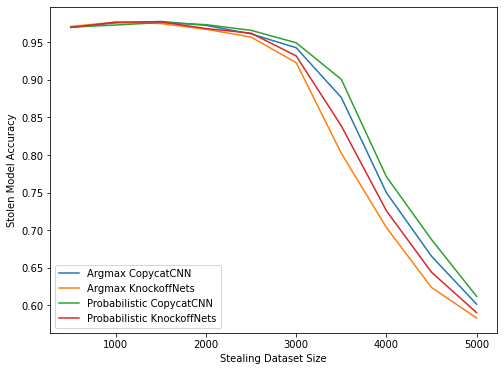

In [ ]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

# Cell 10
# Prepare the defense layer.

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=784,
    nb_classes=2,
    postprocessing_defences=postprocessor
)

# Cell 11
# Extracting protected model.

In [ ]:
num_epochs = 30
len_steal = 5000
results_protected = []
attack_catalogue = {"Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=True),
              "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=False),
              "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=True),
              "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                        batch_size_fit=64,
                                        batch_size_query=64,
                                        nb_epochs=num_epochs,
                                        nb_stolen=len_steal,
                                        use_probability=False),
              }
for len_steal in [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]:
  indices = np.random.permutation(len(X_steal))
  x_steal = X_steal[indices[:len_steal]]
  for name, attack in attack_catalogue.items():
      classifier_stolen = PyTorchClassifier(model,clip_values=(0, 1),loss=criterion,optimizer=optimizer,input_shape=784, nb_classes=2)
      classifier_stolen = attack.extract(x_steal,thieved_classifier=classifier_stolen)
      pred=classifier_stolen.predict(test_dataset.data.numpy().reshape(-1,784)).squeeze()
      accuracy = ((np.round(pred)==test_dataset.targets.numpy()).sum())/len(test_dataset.targets.numpy())
      print(name,accuracy*100)
      results_protected.append((name, len_steal, accuracy))

/usr/local/lib/python3.8/dist-packages/art/defences/postprocessor/reverse_sigmoid.py:91: RuntimeWarning: divide by zero encountered in log
  sigmoid(-self.gamma * np.log((1.0 - preds_clipped_2) / preds_clipped_2)) - 0.5


Probabilistic CopycatCNN (vs. Protected) 58.34515366430259
Argmax CopycatCNN (vs. Protected) 58.34515366430259


Probabilistic KnockoffNets (vs. Protected) 58.250591016548455
Argmax KnockoffNets (vs. Protected) 58.156028368794324


Probabilistic CopycatCNN (vs. Protected) 57.49408983451537


Argmax CopycatCNN (vs. Protected) 57.304964539007095


Probabilistic KnockoffNets (vs. Protected) 57.16312056737589


Argmax KnockoffNets (vs. Protected) 56.59574468085107


Probabilistic CopycatCNN (vs. Protected) 56.59574468085107


Argmax CopycatCNN (vs. Protected) 56.26477541371159


Probabilistic KnockoffNets (vs. Protected) 55.83924349881797


Argmax KnockoffNets (vs. Protected) 55.55555555555556


Probabilistic CopycatCNN (vs. Protected) 55.17730496453901


Argmax CopycatCNN (vs. Protected) 54.60992907801418


Probabilistic KnockoffNets (vs. Protected) 54.184397163120565


Argmax KnockoffNets (vs. Protected) 53.664302600472816


Probabilistic CopycatCNN (vs. Protected) 53.09692671394799


Argmax CopycatCNN (vs. Protected) 52.67139479905437


Probabilistic KnockoffNets (vs. Protected) 52.10401891252955


Argmax KnockoffNets (vs. Protected) 51.205673758865245


Probabilistic CopycatCNN (vs. Protected) 50.92198581560283


Argmax CopycatCNN (vs. Protected) 50.68557919621749


Probabilistic KnockoffNets (vs. Protected) 50.307328605200944


Argmax KnockoffNets (vs. Protected) 50.11820330969267


Probabilistic CopycatCNN (vs. Protected) 49.976359338061464


Argmax CopycatCNN (vs. Protected) 49.40898345153664


Probabilistic KnockoffNets (vs. Protected) 48.93617021276596


Argmax KnockoffNets (vs. Protected) 48.51063829787234


Probabilistic CopycatCNN (vs. Protected) 47.84869976359338


Argmax CopycatCNN (vs. Protected) 47.3758865248227


Probabilistic KnockoffNets (vs. Protected) 47.04491725768322


Argmax KnockoffNets (vs. Protected) 46.808510638297875


Probabilistic CopycatCNN (vs. Protected) 46.52482269503546


Argmax CopycatCNN (vs. Protected) 46.43026004728132


Probabilistic KnockoffNets (vs. Protected) 46.38297872340426
Argmax KnockoffNets (vs. Protected) 46.38297872340426
Probabilistic CopycatCNN (vs. Protected) 46.38297872340426
Argmax CopycatCNN (vs. Protected) 46.38297872340426
Probabilistic KnockoffNets (vs. Protected) 46.335697399527184
Argmax KnockoffNets (vs. Protected) 46.335697399527184


# Cell 12
# Plotting stolen model's accuracy.

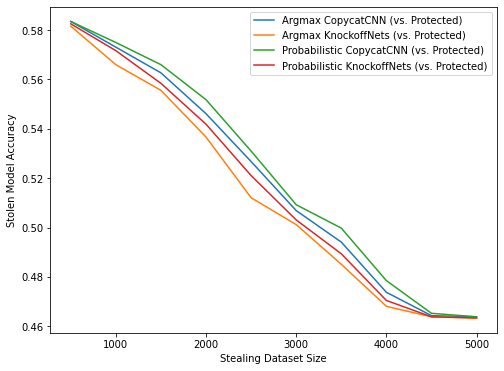

In [ ]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

# Cell 13
# Comparing unprotected and protected models.

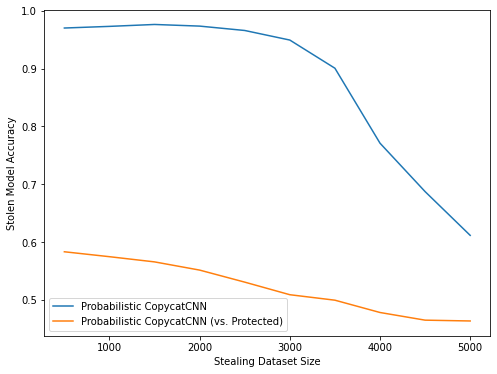

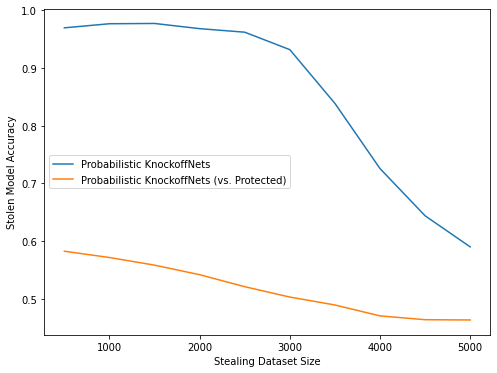

In [ ]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()